Lab 5: Processing citizen science and geodata
============================================

In this lab we will predict the presence of parakeets. We'll use both citizen science and remote-sensing data, and make sure that we map them onto the same geographic grid.

One of the most important things in this lab is how to handle geodata correctly.

Lab 5 part a: Loading citizen science point observations
-------------------------

Here we use 2 types of observations from citizen science projects. In both cases the data are **"point observations"**, i.e. each row in the dataset is a single observation with an exact GPS latitude and longitude. In order to analyse it, we will have to map those onto a geographic grid by counting the number of observations in each "cell"/"pixel". This is very similar to constructing a histogram.

In [1]:
# import packages
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import ndimage
import csv, os

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 8, 6


First we load the parakeet data that we already used in an earlier lab

In [2]:
# CHANGE the path
filepath_parakeets = 'datasets/parakeetsNL400observations/occurrence_parakeetsNL_roseringed.tsv'
df_p = pd.read_csv(filepath_parakeets, delimiter="\t", low_memory=False)
crs_e = 'epsg:4326'
gdf_p = gpd.GeoDataFrame(df_p,
        crs=crs_e,
        geometry=gpd.points_from_xy(df_p['decimalLongitude'], df_p['decimalLatitude']))

print(f"Loaded {len(gdf_p)} rows")
gdf_p.head()

Loaded 73447 rows


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,basisOfRecord,institutionCode,collectionCode,catalogNumber,identifiedBy,license,rightsHolder,recordedBy,mediaType,geometry
0,979544661,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS240283283,Animalia,Chordata,Aves,Psittaciformes,Psittacidae,Psittacula,Psittacula krameri,...,HUMAN_OBSERVATION,CLO,EBIRD,OBS240283283,NaN,CC_BY_4_0,NaN,obsr240555,NaN,POINT (4.86751 52.35794)
1,979313695,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS239103121,Animalia,Chordata,Aves,Psittaciformes,Psittacidae,Psittacula,Psittacula krameri,...,HUMAN_OBSERVATION,CLO,EBIRD,OBS239103121,NaN,CC_BY_4_0,NaN,obsr370975,NaN,POINT (4.90872 52.36755)
2,979049243,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS237336989,Animalia,Chordata,Aves,Psittaciformes,Psittacidae,Psittacula,Psittacula krameri,...,HUMAN_OBSERVATION,CLO,EBIRD,OBS237336989,NaN,CC_BY_4_0,NaN,obsr428923,NaN,POINT (4.47002 51.90475)
3,979048328,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS237336763,Animalia,Chordata,Aves,Psittaciformes,Psittacidae,Psittacula,Psittacula krameri,...,HUMAN_OBSERVATION,CLO,EBIRD,OBS237336763,NaN,CC_BY_4_0,NaN,obsr428923,NaN,POINT (4.91900 52.36005)
4,977840381,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS227514482,Animalia,Chordata,Aves,Psittaciformes,Psittacidae,Psittacula,Psittacula krameri,...,HUMAN_OBSERVATION,CLO,EBIRD,OBS227514482,NaN,CC_BY_4_0,NaN,obsr450784,NaN,POINT (4.86751 52.35794)


<Axes: >

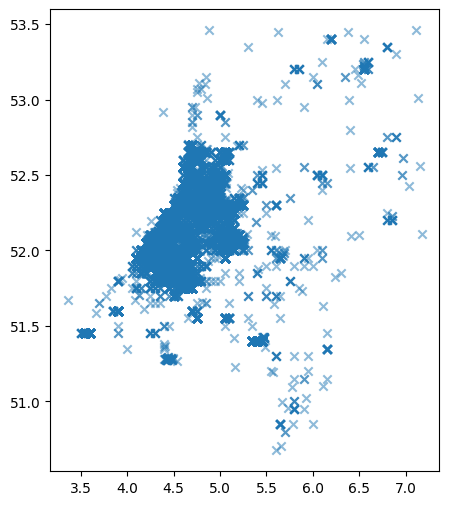

In [3]:
gdf_p.plot(marker='x', alpha=0.5)

Let's inspect the values of the "individualCount" column, using the `value_counts()` function.

For each row in the parakeet dataset, "individualCount" gives us a quantity (i.e. how many parrots).

What is the most common quantity? What is the highest quantity?

In [4]:
# Your code here
gdf_p['individualCount'].value_counts()


individualCount
1.0      35902
2.0      14079
3.0       5529
4.0       4193
5.0       2697
         ...  
155.0        1
118.0        1
138.0        1
857.0        1
904.0        1
Name: count, Length: 269, dtype: int64

Bounding box extent: (3.363499, 7.172894, 53.458631, 50.67606)


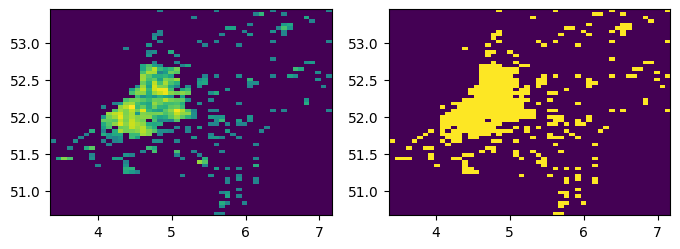

In [5]:
# Next let's summarise the data in a 2D histogram

nbins=(60, 50)

# Note that we are re-using the x and y "edges" to make sure the two datasets are histogrammed the same way
heatmap_parakeet, xedges, yedges = np.histogram2d(gdf_p.decimalLatitude, gdf_p.decimalLongitude, bins=nbins)
extent = (yedges[0], yedges[-1], xedges[-1], xedges[0])
print(f"Bounding box extent: {extent}")

# Now calculate two derived versions of this:
#  (a) Take the logarithm of the values (making sure to avoid log(0) ) and plot this
#  (b) Calculate the "occupancy" map with 1 for "present" and 0 for "absent"
#             (store the "occupancy" data -- we'll use it later)

# Your code here

heatmap_parakeet [heatmap_parakeet <= 0] = 1e-3 # Avoid pure-zeros, since we'll be taking the logarithm Logheatmap_parakeet = np.log(heatmap_parakeet)
logheatmap_parakeet = np.log(heatmap_parakeet)
occmap_parakeet = heatmap_parakeet >= 1
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(logheatmap_parakeet, cmap='viridis', extent=extent)
ax[0].invert_yaxis()
ax[1].imshow(occmap_parakeet, cmap='viridis', extent=extent)
ax[1].invert_yaxis()



Next we load geolocations of individual trees, logged in [OpenStreetMap](https://openstreetmap.org/)

In [6]:
# CHANGE this path
filepath_treedata = 'datasets/netherlands-latest-greptree-coordinates.csv'

# Load the CSV data
df_t = pd.read_csv(filepath_treedata, names=["lat", "lon"])
#print(df_t.head())

# Convert it from Pandas to GeoPandas format
gdf_t = gpd.GeoDataFrame(
    df_t, geometry=gpd.points_from_xy(df_t.lon, df_t.lat), crs="EPSG:4326"
)

print(f"Loaded {len(gdf_t)} rows")
gdf_t.head()
# Look at the output of this. What's the difference between gdf_t and df_t?

Loaded 363569 rows


,lat,lon,geometry
0,51.431865,5.479549,POINT (5.47955 51.43186)
1,51.839527,5.861621,POINT (5.86162 51.83953)
2,52.336917,4.905027,POINT (4.90503 52.33692)
3,52.372369,4.623965,POINT (4.62397 52.37237)
4,52.388697,4.684993,POINT (4.68499 52.38870)


In [7]:
# You can do a scatter plot like this BUT with 300k points, it might take a long time to render
# gdf_t.plot(alpha=0.3, marker=".")

In [8]:
# Instead we'll make a histogram across 2D geographic pixels, and show it as a heatmap
heatmap_tree, _, _ = np.histogram2d(gdf_t.lat, gdf_t.lon, bins=[xedges, yedges])

Text(0.5, 1.0, 'Tree density in the Netherlands (OpenStreetMap)')

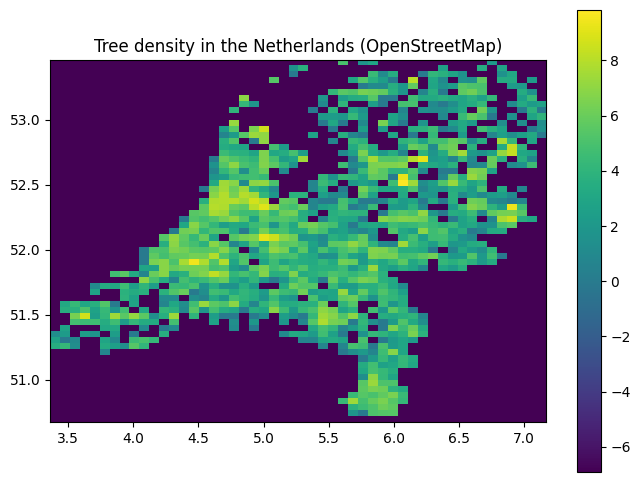

In [9]:
# Again take the logarithm of the values and then plot those

# Your code here

heatmap_tree[heatmap_tree <= 0]= 1e-3 # Avoid pure-zeros, since we'll be taking the logarithm to plot logheatmap_tree = np.log(heatmap_tree)
logheatmap_tree = np.log(heatmap_tree)
plt.imshow(logheatmap_tree, cmap='viridis', extent=extent)
plt.colorbar ()
plt.gca().invert_yaxis()
plt.title("Tree density in the Netherlands (OpenStreetMap)")

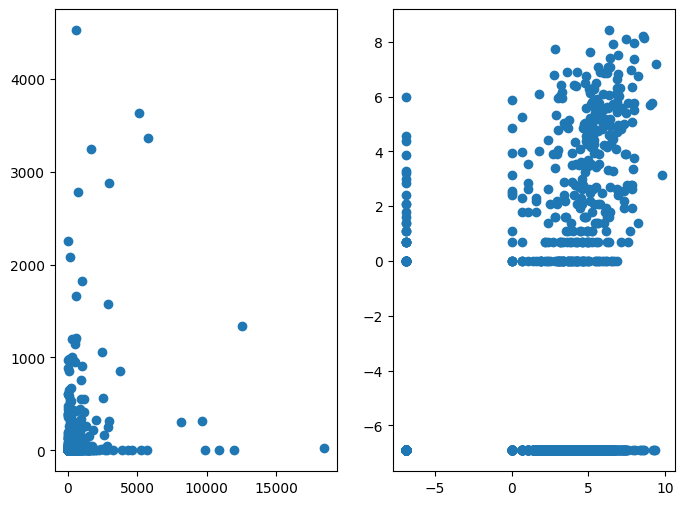

In [10]:
# Now let's create a scatter plot using the density values we've calculated.
# Do NOT use the raw geodata for this, but the "heatmap_tree" and "heatmap_parakeet".
#
# Make a scatter plot of the parakeet density against the tree density.
# You could try plotting both the log and non-log version.

# Your code here
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(heatmap_tree, heatmap_parakeet)
ax[1].scatter(logheatmap_tree, logheatmap_parakeet)

Does there appear to be a relationship between the tree density and the parakeet density?

Is there anything about the way the relationship has been calculated that could be better?

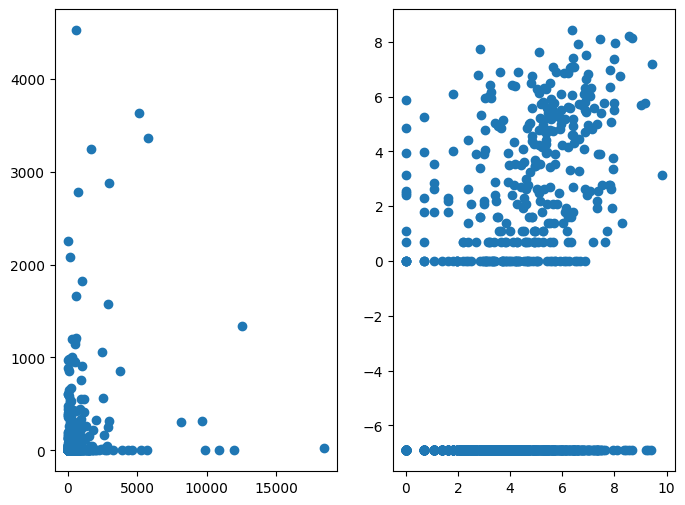

In [11]:
#ONE ANSWER: Many of the empty pixels are empty because they are water.|
# Let's handle that approximately by assuming that any cell with exactly zerd trees is water, and to be ignored.

hastrees = heatmap_tree >= 1
fig, ax = plt.subplots(ncols=2)
ax[0].scatter (heatmap_tree [hastrees], heatmap_parakeet [hastrees])
ax[1].scatter (logheatmap_tree [hastrees], logheatmap_parakeet [hastrees])

Lab 5 part b: Remote sensing data
--------------------

Next we load the remote-sensing data from Corinne Land Cover ("CLC"), the EU's satellite service that gives estimates of the land-use type.

The data from CLC is not point observations; instead it's more like *segmentation* data, lots of polygons each with labels. Each area is given a land-use code such as "142", where the first digit is the broad category):

1. Artificial Surfaces (including many city areas)
2. Agricultural areas
3. Forest and seminatural areas
4. Wetlands
5. Water bodies

...and the second and third digits give extra detail. [The full CLC classification is listed here.](https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/html/) The code is stored in the column called `Code_18`.

We will load the data, and for each pixel we are analysing, we need to perform a geographic lookup to decide which of the 5 main land-use areas it is in. Luckily, GeoPandas makes this easy.

In [ ]:
import fiona
print(fiona.__version__)
# if 1.10.0 then
!pip uninstall fiona
!pip install fiona==1.9.6

In [28]:
# if fiona version bigger than 1.9.6 then downgrade it to 1.9.6
import fiona
print(fiona.__version__)
if fiona.__version__ > '1.9.6':
    !pip uninstall fiona
    !pip install fiona==1.9.6
    print(fiona.__version__)

In [12]:
# CHANGE the path
filepath_clc = os.path.expanduser("~/Documents/tilnat/teaching_planning/ai4ne/datasets/clc2018_preprocessed_nl.gpkg")
filepath_clc = 'datasets/clc2018_preprocessed_nl.gpkg'
gdf_clc = gpd.read_file(filepath_clc)
print(f"Loaded {len(gdf_clc)} rows")
gdf_clc.head()

Loaded 26408 rows


,Code_18,ID,toplev,geometry
0,211,EU_557386,2,"MULTIPOLYGON (((2.85024 51.19835, 2.84989 51.1..."
1,231,EU_566461,2,"MULTIPOLYGON (((2.73261 50.96715, 2.73250 50.9..."
2,112,EU_544537,1,"MULTIPOLYGON (((3.05565 51.15477, 3.05590 51.1..."
3,242,EU_574978,2,"MULTIPOLYGON (((2.75438 50.97850, 2.75635 50.9..."
4,112,EU_544305,1,"MULTIPOLYGON (((2.87712 51.03734, 2.87689 51.0..."


In the output from the above code, you should see that the `geometry` for the data you have loaded is very different from the points or the pixel-grids that we've seen so far. In fact each row contains a shape, as we can see by plotting for example the 10th row on its own:

Code_18                                                   112
ID                                                  EU_544156
toplev                                                      1
geometry    MULTIPOLYGON (((2.9596881212217077 50.97750675...
Name: 10, dtype: object


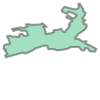

In [13]:
print(gdf_clc.iloc[10])
gdf_clc.iloc[10].geometry  # jupyter should plot it for us

In order to create a grid of values, we will perform a **[spatial join](https://geopandas.org/docs/reference/api/geopandas.sjoin.html)**. This is like a "join" of two database tables, but making use of spatial relationships.

In [14]:
# First we create a MESHGRID, where each datapoint represents the location of one pixel
clcgrid = np.array([[x, y] for x in xedges[:-1] for y in yedges[:-1]])
clcgrid = gpd.GeoDataFrame(crs=crs_e, geometry=gpd.points_from_xy(clcgrid[:,1], clcgrid[:,0]))

# Next, the spatial join will add the CLC values to these pixel positions,
#   by finding which shape intersects each pixel
clcgrid = gpd.sjoin(clcgrid, gdf_clc, how="left", predicate="intersects")

# some pixels (in the sea) do not get categorised, and the spatial join leaves them as "NA". Thus we must fix them:
clcgrid['toplev'] = clcgrid['toplev'].fillna(0).astype('int8')
print(clcgrid.head())

                   geometry  index_right Code_18         ID  toplev
0  POINT (3.36350 50.67606)       2485.0     211  EU_555618       2
1  POINT (3.43969 50.67606)       2485.0     211  EU_555618       2
2  POINT (3.51587 50.67606)       2485.0     211  EU_555618       2
3  POINT (3.59206 50.67606)          NaN     NaN        NaN       0
4  POINT (3.66825 50.67606)          NaN     NaN        NaN       0


In [15]:
clcgrid.toplev.value_counts(dropna=False)

toplev
2    1373
0     459
5     440
1     371
3     265
4      92
Name: count, dtype: int64

In [16]:
clcgrid

,geometry,index_right,Code_18,ID,toplev
0,POINT (3.36350 50.67606),2485.0,211,EU_555618,2
1,POINT (3.43969 50.67606),2485.0,211,EU_555618,2
2,POINT (3.51587 50.67606),2485.0,211,EU_555618,2
3,POINT (3.59206 50.67606),NaN,NaN,NaN,0
4,POINT (3.66825 50.67606),NaN,NaN,NaN,0
...,...,...,...,...,...
2995,POINT (6.79195 53.41225),12720.0,211,EU_1588800,2
2996,POINT (6.86814 53.41225),12720.0,211,EU_1588800,2
2997,POINT (6.94433 53.41225),25493.0,522,EU_2372325,5
2998,POINT (7.02052 53.41225),13058.0,231,EU_1692821,2


In [17]:
# In order to plot the grid, we need to make the x and y columns explicit again
clcgrid['x'] = clcgrid.geometry.x
clcgrid['y'] = clcgrid.geometry.y

import rioxarray

# and then we output the pixel values directly, like we would with image data
da = (
    clcgrid.set_index(["y", "x"])
    .to_xarray()
)
print(da)

<xarray.Dataset>
Dimensions:      (y: 60, x: 50)
Coordinates:
  * y            (y) float64 50.68 50.72 50.77 50.82 ... 53.27 53.32 53.37 53.41
  * x            (x) float64 3.363 3.44 3.516 3.592 ... 6.868 6.944 7.021 7.097
Data variables:
    geometry     (y, x) object POINT (3.363499 50.67606) ... POINT (7.0967061...
    index_right  (y, x) float64 2.485e+03 2.485e+03 ... 1.306e+04 2.636e+04
    Code_18      (y, x) object '211' '211' '211' nan ... '211' '522' '231' '231'
    ID           (y, x) object 'EU_555618' 'EU_555618' ... 'EU_1693141'
    toplev       (y, x) int8 2 2 2 0 0 0 0 0 0 0 0 0 ... 3 4 2 2 2 2 2 2 2 5 2 2


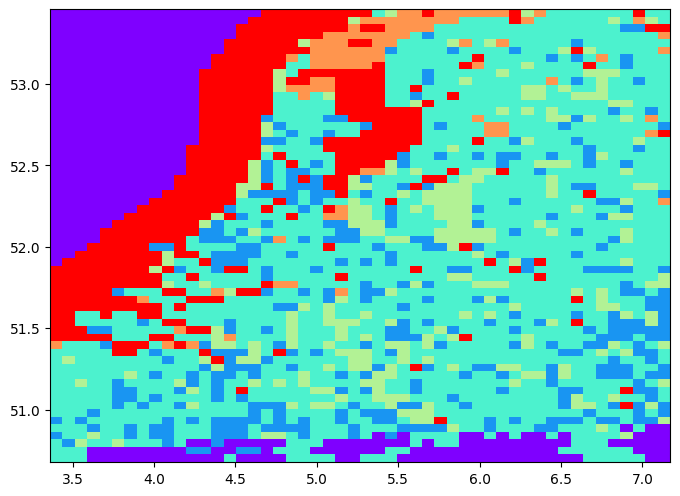

In [18]:
fig, ax = plt.subplots(ncols=1)
ax.imshow(da.toplev, cmap='rainbow', extent=extent)
ax.invert_yaxis()

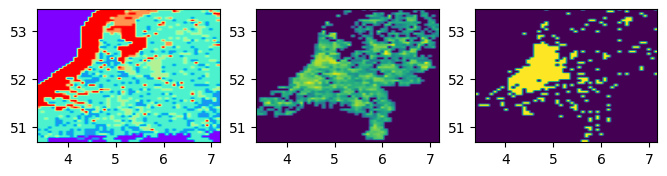

In [19]:
# Here we can plot the datasets together, that will be combined.
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(da.toplev, cmap='rainbow', extent=extent)
ax[0].invert_yaxis()
ax[1].imshow(logheatmap_tree, cmap='viridis', extent=extent)
ax[1].invert_yaxis()
ax[2].imshow(occmap_parakeet, cmap='viridis', extent=extent)
ax[2].invert_yaxis()


Now create a **unified** dataframe of features, including:

* the CLC landcover data. But, note that the "toplev" is a categorical feature, using the CLC values (1,2,3,4,5). We would like to represent these as *one-hot* features, for example a binary feature `toplev1`, a binary feature `toplev2`, etc. The Pandas `get_dummies()` function can help.
* heatmap_tree
* heatmap_parakeet
* occmap_parakeet

Since all the datasets that we have loaded/created contain the same pixels in the same order, you can combine them using `pd.concat(..., axis=1)`

In [20]:
#Your code here

combined = pd.concat([clcgrid, pd.get_dummies(clcgrid. toplev, prefix="toplev")], axis=1)

combined['heatmap_parakeet'] = heatmap_parakeet. flatten()
combined['occmap_parakeet'] = occmap_parakeet.flatten()
combined[ 'heatmap_tree'] = heatmap_tree.flatten()

combined.head ()

,geometry,index_right,Code_18,ID,toplev,x,y,toplev_0,toplev_1,toplev_2,toplev_3,toplev_4,toplev_5,heatmap_parakeet,occmap_parakeet,heatmap_tree
0,POINT (3.36350 50.67606),2485.0,211,EU_555618,2,3.363499,50.67606,False,False,True,False,False,False,0.001,False,0.001
1,POINT (3.43969 50.67606),2485.0,211,EU_555618,2,3.439687,50.67606,False,False,True,False,False,False,0.001,False,0.001
2,POINT (3.51587 50.67606),2485.0,211,EU_555618,2,3.515875,50.67606,False,False,True,False,False,False,0.001,False,0.001
3,POINT (3.59206 50.67606),NaN,NaN,NaN,0,3.592063,50.67606,True,False,False,False,False,False,0.001,False,0.001
4,POINT (3.66825 50.67606),NaN,NaN,NaN,0,3.668251,50.67606,True,False,False,False,False,False,0.001,False,0.001


Lab 5 part c: automatic classification
============================

We have now assembled data from multiple sources, into the same format:

* Citizen science bird observations
* Citizen science tree observations
* Remote sensing land-use categories

Let's now use a machine learning algorithm on a **per-pixel** basis, to **predict whether a square has parakeets or not**, using the tree data and the land-use data.

Use `LogisticRegression` from `sklearn` to train a classifier on 80% of the data, and then evaluate it on the remaining 20%.

Measure the *accuracy* of the model, and also the F-score (`sklearn.metrics.f1_score`).

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test,y_train, y_test = train_test_split(
    combined[['heatmap_tree', 'toplev_1', 'toplev_2', 'toplev_3', 'toplev_4', 'toplev_5']],
    combined['occmap_parakeet'],
    test_size=0.2, random_state=42)

logreg = LogisticRegression(fit_intercept=True, solver='liblinear')

# Now fit the model, and calc the F1 score
# Your code here
logreg.fit(X_train, y_train)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, logreg.predict(X_test))

matches = logreg.predict(X_test) == y_test
acc = sum(matches) / len(matches)
print(f"Measured accuracy: {acc * 100}%; F1 score: {f1*100}%")

Measured accuracy: 86.5%; F1 score: 10.989010989010987%


Also find an estimate of which of the features is best for predicting `occmap_parakeet`. Does it come from the remote sensing data or the citizens' tree data?

In [22]:
# Your code here, for finding the best features

print(f"Intercept: {logreg.intercept_}")
print(f"Coefficients: {logreg.coef_.round(2)}")
del logreg  # save memory

Intercept: [-3.41419421]
Coefficients: [[0.   1.87 1.51 1.43 1.23 1.63]]


Next, repeat the classification experiment, but instead of using the standard train-test splitting from sklearn, use a GEO STRATIFIED SPLIT. In order to do this, use longitudes HIGHER than 5 as training data, and LOWER than 5 as testing data.


In [23]:
strat_train = combined [combined.geometry.x > 5]
strat_test = combined [combined.geometry.x <= 5]
print(len(strat_train))
print (len(strat_test))
X_train = strat_train[['heatmap_tree', 'toplev_1', 'toplev_2', 'toplev_3', 'toplev_4', 'toplev_5']]
X_test = strat_test[ ['heatmap_tree', 'toplev_1', 'toplev_2', 'toplev_3', 'toplev_4', 'toplev_5']]
y_train = strat_train['occmap_parakeet']
y_test = strat_test['occmap_parakeet']

1680
1320


In [24]:
logreg = LogisticRegression(fit_intercept=True, solver='liblinear')
logreg.fit(X_train, y_train)
matches = logreg.predict (X_test) == y_test 
acc = sum(matches) / len (matches)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, logreg.predict(X_test))
print(f"Measured accuracy: {acc* 100}%; F1-score: {f1 * 100}%") 
del logreg # save memory

Measured accuracy: 82.27272727272728%; F1-score: 2.5%


Which of the two experiments gives you the evaluation measure that is the most **realistic** assessment of how this prediction model would work when applied to new data? Why?

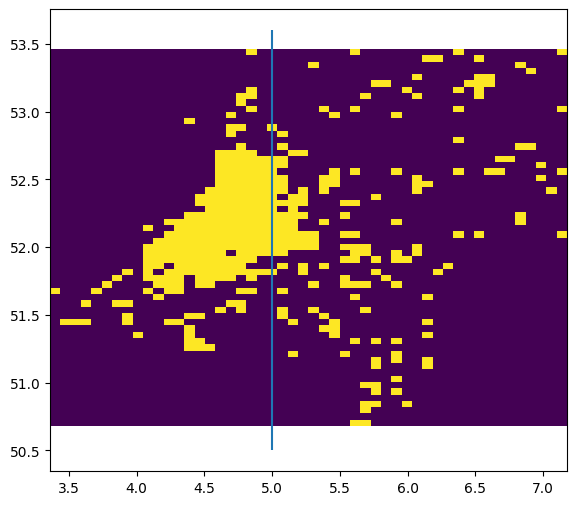

In [25]:
fig, ax = plt.subplots (ncols=1)
ax.imshow(occmap_parakeet, cmap='viridis', extent=extent)
ax.invert_yaxis()
ax.vlines (5, 50.5, 53.6)

In this lab we have used Logistic Regression to predict the parakeets in a pixel, from the features of that pixel. Could we do better with CNNs, or with Transformers? If so why?

In [26]:
#?


OPTIONAL EXTRA: Apply a CNN or Transformer to the preprocessed pixel data above.